In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random

def positive_lattice_random_step(state, p):
    i = np.random.choice(range(4), p=(p/2,p/2,(1-p)/2,(1-p)/2))
    if i == 0:
        new_state = (state[0] + 1, state[1])
    elif i == 1:
        new_state = (state[0], state[1] + 1)
    elif i == 2 and state[0] > 1:
        new_state = (state[0] - 1, state[1])
    elif i == 3 and state[1] > 1:
        new_state = (state[0], state[1] - 1)
    else:
        new_state = state
    return new_state

def positive_lattice_random_walk(state, p, n=1000):
    li = [state]
    for _ in range(n):
        state = positive_lattice_random_step(state, p)
        li.append(state)
    return li

def ring_graph(n):
    edges = np.zeros((n, 3), dtype=np.int32)
    probs = [0.25, 0.75, 1]*np.ones((n, 3))

    for i in range(1, n-1):
        edges[i] = np.array([i-1, i, i+1])
    
    edges[0] = np.array([n-1, 0, 1])
    edges[n-1] = np.array([n-2, n-1, 0])
    
    stat_dist = 1/100 * np.ones(n)
    
    return edges, probs, stat_dist

def full_binary_tree_graph(n):
    x = np.floor(np.log2(n))
    last_level = 2 ** (x - 1) + (n - 2 ** x)//2
    
    edges = np.zeros((n, 4), dtype=np.int32)
    probs = np.ones((n, 4))
    stat_dist = np.ones(n)
    
    stat_dist[0] = 2
    probs[:, 0] = 0.5
    for i in range(n):
        edges[i][0] = i
    
    probs[0][1] = 0.75
    edges[0][1] = 1
    edges[0][2] = 2
    
    for i in range(1, int(last_level)):
        probs[i][1] = 0.5 + 1/6
        probs[i][2] = 0.5 + 1/3
        
        edges[i][2] = 2*i
        edges[i][3] = 2*i + 1
        
        stat_dist[i] = 3
    
    for i in range(1, n):
        edges[i][1] = i // 2
    
    stat_dist *= 1/200
        
    return edges, probs, stat_dist

def grid_graph(n):
    # +1: direita, -1: esquerda, +l: baixo, -l: cima
    edges = np.zeros((n, 5), dtype=np.int32)
    probs = np.ones((n, 5))
    stat_dist = np.ones(n)
    
    probs[:, 0] = 0.5
    for i in range(n):
        edges[i][0] = i
    
    l = int(np.sqrt(n))
    
    corners = {0: [1, l],                           # +1, +l
               l - 1: [l - 2, 2 * l - 1],           # -1, +l
               n - l: [n - 2 * l, n - l + 1],       # +1, -l
               n - 1: [n - l - 1, n - 2]}           # -1, -l
    
    for i in corners:
        edges[i][1:3] = corners[i]
        probs[i][1] = 0.75
        stat_dist[i] = 2

    for r in range(2, l):
        for s in range(1, l - 1):
            sides = {s: [s - 1, s + 1, s + l],                                  # -1, +1, +l
                     l*s: [l*s + 1, l*(s - 1), l*(s + 1)],                      # +1, -l, +l
                     l*r - 1: [l*r - 2, l*(r - 1) - 1, l*(r + 1) - 1],          # -1, -l, +l
                     n - l + s: [n - 2*l + s, n - l + s - 1, n - l + s + 1]}    # -1, +1, -l
            side_probs = [2/3, 5/6]
            for i in sides:
                edges[i][1:4] = sides[i]
                probs[i][1:3] = side_probs
                stat_dist[i] = 3
    
    for r in range(1, l - 1):
        for s in range(1, l - 1):
            inside_probs = [5/8, 3/4, 7/8]
            edges[l*r + s][1:] = [l*(s - 1) + s, l*r + s - 1, l*r + s + 1, l*(s + 1) + s]    # +/-1, +/-l
            probs[l*r + s][1:4] = inside_probs
            stat_dist[l*r + s] = 4
    
    stat_dist *= 1/360
        
    return edges, probs, stat_dist

def total_variation(graph, probs, stat_dist, state=0, path_length=1000):
    dist = np.zeros(n)
    dist[state] = 1

    variation = []

    for i in range(1, path_length + 1):
        u = random.random()
        for j in range(graph[state].size):
            if u < probs[state][j]:
                new_state = graph[state][j]
                break
        state = new_state
        dist[state] += 1 / i
        dist *= i / (i + 1)
    
        variation.append(1/2 * np.linalg.norm(dist - stat_dist, 1))
        
    return variation

def plotting_function(variation, title):
    plt.plot(range(1, len(variation) + 1), variation)
    plt.xscale('log')
    plt.yscale('log')
    plt.title(title)
    plt.xlabel('Tempo')
    plt.ylabel('Variação Total')
    plt.show()

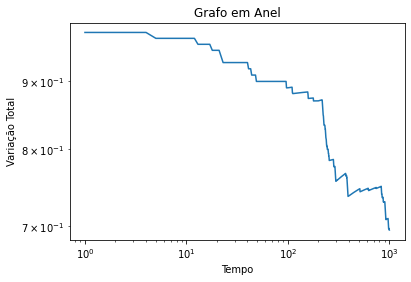

In [2]:
n = 100
graph, probs, stat_dist = ring_graph(n)

ring_variation = total_variation(graph, probs, stat_dist)
plotting_function(ring_variation, 'Grafo em Anel')

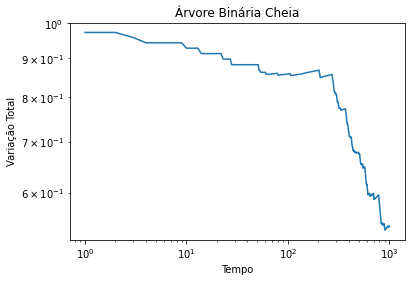

In [15]:
n = 100
graph, probs, stat_dist = full_binary_tree_graph(n)

tree_variation = total_variation(graph, probs, stat_dist, state=0, path_length=1000)
plotting_function(tree_variation, 'Árvore Binária Cheia')

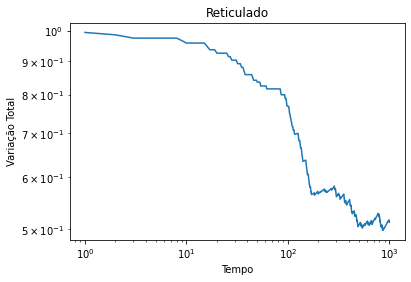

In [12]:
n = 100
graph, probs, stat_dist = grid_graph(n)

grid_variation = total_variation(graph, probs, stat_dist, state=0, path_length=1000)
plotting_function(grid_variation, 'Reticulado')

In [5]:
# calculando a distribuição estacionária de (1, 1) diretamente
probs = [0.25, 0.35, 0.45]
state = (1, 1)
n = 10000

for p in probs:
    path = positive_lattice_random_walk(state, p, n=n)
    count = 0
    for i in range(len(path)):
        if path[i] == (1, 1):
            count += 1

    print('Probabilidade estacionária do estado (1, 1) para p = ' + str(p) + ':', count/n)

Probabilidade estacionária do estado (1, 1) para p = 0.25: 0.4486
Probabilidade estacionária do estado (1, 1) para p = 0.35: 0.2115
Probabilidade estacionária do estado (1, 1) para p = 0.45: 0.047


In [6]:
# calculando a distribuição estacionária de (1, 1) utilizando os tempos de retorno
probs = [0.25, 0.35, 0.45]
state = (1, 1)
n = 10000

for p in probs:
    path = positive_lattice_random_walk(state, p, n=n)
    return_times = []
    count = 0
    for i in range(len(path)):
        count += 1
        if path[i] == (1, 1):
            return_times.append(count)
            count = 0

    print('Probabilidade estacionária do estado (1, 1) para p = ' + str(p) + ':', 1/np.mean(return_times))

Probabilidade estacionária do estado (1, 1) para p = 0.25: 0.44483415171860907
Probabilidade estacionária do estado (1, 1) para p = 0.35: 0.19536888532477947
Probabilidade estacionária do estado (1, 1) para p = 0.45: 0.02842842842842843


In [7]:
N = 100    # número de vezes que rodamos cada programa
time = [10, 100, 1000]
dists = np.zeros(N)
state = (20, 20)    # estado inicial

for p in probs:
    for t in time:
        for n in range(N):
            path = positive_lattice_random_walk(state, p, t)
            x = np.asarray(path[-1])
            dists[n] = np.linalg.norm(np.array([1, 1]) - x, 1)
        print('Distância média entre (1, 1) e X_t para t =', t,'e p = ' + str(p) + ':', np.mean(dists))

Distância média entre (1, 1) e X_t para t = 10 e p = 0.25: 32.86
Distância média entre (1, 1) e X_t para t = 100 e p = 0.25: 1.67
Distância média entre (1, 1) e X_t para t = 1000 e p = 0.25: 0.9
Distância média entre (1, 1) e X_t para t = 10 e p = 0.35: 35.16
Distância média entre (1, 1) e X_t para t = 100 e p = 0.35: 11.06
Distância média entre (1, 1) e X_t para t = 1000 e p = 0.35: 1.97
Distância média entre (1, 1) e X_t para t = 10 e p = 0.45: 37.12
Distância média entre (1, 1) e X_t para t = 100 e p = 0.45: 28.3
Distância média entre (1, 1) e X_t para t = 1000 e p = 0.45: 9.77
